# settings

In [5]:
import pandas as pd
import numpy as np
import warnings

In [6]:
from datetime import datetime, timedelta

In [28]:
import matplotlib.pyplot as plt

In [7]:
import requests
import json

In [3]:
import pickle

In [8]:
key = '68bd382ddb99350655bff0bbf00171ec'

In [9]:
#timestamp day before yesterday
times = int(datetime.timestamp(datetime.now()- timedelta(days = 2)))

# model import

In [4]:
#model_xgb = pickle.load(open('model/pm25_model_xgb.pkl', 'rb'))

In [30]:
with open(f'model/pm25_model_xgb.pkl', 'rb') as f:
    model_xgb = pickle.load(f)

# data for forcast and chart

### data from darksky

In [10]:
dark_hour = []

In [11]:
for i in range(5):
    darksky = json.loads(requests.get('https://api.darksky.net/forecast/{}/52.2193,21.0047,{}'.format(key, times)).text)
    dark_hour.extend(darksky['hourly']['data'])
    times += 24*60*60

In [12]:
table_hour = pd.DataFrame(dark_hour) 
table_hour.head()

,apparentTemperature,cloudCover,dewPoint,humidity,icon,ozone,precipIntensity,precipProbability,precipType,pressure,summary,temperature,time,uvIndex,visibility,windBearing,windGust,windSpeed
0,31.72,0.08,28.11,0.66,clear-night,337.8,0.0000,0.00,NaN,1005.6,Clear,38.32,1583449200,0,10.0,144,24.13,9.65
1,30.13,0.10,27.92,0.69,clear-night,334.2,0.0002,0.01,rain,1005.2,Clear,37.10,1583452800,0,10.0,140,24.94,9.82
2,29.91,0.09,28.20,0.71,clear-night,331.5,0.0000,0.00,NaN,1004.5,Clear,36.88,1583456400,0,10.0,134,24.89,9.72
3,29.26,0.10,28.01,0.71,clear-night,330.8,0.0000,0.00,NaN,1003.7,Clear,36.55,1583460000,0,10.0,129,24.47,10.22
4,28.42,0.14,27.91,0.72,clear-night,330.8,0.0000,0.00,NaN,1002.7,Clear,36.08,1583463600,0,10.0,127,24.44,10.80


### checking if there are any missing variables

In [13]:
table_hour.columns

Index(['apparentTemperature', 'cloudCover', 'dewPoint', 'humidity', 'icon',
       'ozone', 'precipIntensity', 'precipProbability', 'precipType',
       'pressure', 'summary', 'temperature', 'time', 'uvIndex', 'visibility',
       'windBearing', 'windGust', 'windSpeed'],
      dtype='object')

In [14]:
available_var = list(set(table_hour.columns) - set(['icon','ozone', 'summary', 'time', 'precipType']))
missing_var = list(set(['apparentTemperature', 'cloudCover', 'dewPoint', 'humidity', 
         'precipAccumulation', 'precipIntensity', 'precipProbability',
         'pressure', 'temperature',  'uvIndex',
         'visibility', 'windBearing', 'windGust', 'windSpeed']) - set(available_var))

In [15]:
if (len(missing_var)>0):
    for var in missing_var:
        table_hour[var] = 0

### adding time variables

In [16]:
table_hour['date'] = table_hour['time'].apply(lambda x: datetime.fromtimestamp(x))
table_hour['year'] = table_hour['date'].apply(lambda x: x.year)
table_hour['month'] = table_hour['date'].apply(lambda x: x.month)
table_hour['day'] = table_hour['date'].apply(lambda x: x.day)
table_hour['hour'] = table_hour['date'].apply(lambda x: x.hour)
table_hour['day_of_week'] = table_hour['date'].apply(lambda x: x.isocalendar()[2])
table_hour['no_of_week'] = table_hour['date'].apply(lambda x: x.isocalendar()[1])

In [17]:
table_hour.columns

Index(['apparentTemperature', 'cloudCover', 'dewPoint', 'humidity', 'icon',
       'ozone', 'precipIntensity', 'precipProbability', 'precipType',
       'pressure', 'summary', 'temperature', 'time', 'uvIndex', 'visibility',
       'windBearing', 'windGust', 'windSpeed', 'precipAccumulation', 'date',
       'year', 'month', 'day', 'hour', 'day_of_week', 'no_of_week'],
      dtype='object')

In [18]:
table_hour.head()

,apparentTemperature,cloudCover,dewPoint,humidity,icon,ozone,precipIntensity,precipProbability,precipType,pressure,...,windGust,windSpeed,precipAccumulation,date,year,month,day,hour,day_of_week,no_of_week
0,31.72,0.08,28.11,0.66,clear-night,337.8,0.0000,0.00,NaN,1005.6,...,24.13,9.65,0,2020-03-06 00:00:00,2020,3,6,0,5,10
1,30.13,0.10,27.92,0.69,clear-night,334.2,0.0002,0.01,rain,1005.2,...,24.94,9.82,0,2020-03-06 01:00:00,2020,3,6,1,5,10
2,29.91,0.09,28.20,0.71,clear-night,331.5,0.0000,0.00,NaN,1004.5,...,24.89,9.72,0,2020-03-06 02:00:00,2020,3,6,2,5,10
3,29.26,0.10,28.01,0.71,clear-night,330.8,0.0000,0.00,NaN,1003.7,...,24.47,10.22,0,2020-03-06 03:00:00,2020,3,6,3,5,10
4,28.42,0.14,27.91,0.72,clear-night,330.8,0.0000,0.00,NaN,1002.7,...,24.44,10.80,0,2020-03-06 04:00:00,2020,3,6,4,5,10


### handling missing data

In [19]:
# interpolate
cols=[ 'apparentTemperature', 'cloudCover', 'dewPoint',
       'humidity',  'precipType', 'pressure', 'temperature',
       'time', 'uvIndex', 'visibility', 'windBearing',
       'windSpeed']

for col in cols:
    table_hour[col] = table_hour[col].interpolate(limit_direction='both')

In [20]:
# fill with 0
cols=['precipAccumulation','precipIntensity','precipProbability']

for col in cols:
    table_hour[col] = table_hour[col].fillna(0)

In [21]:
# value from another column
table_hour['windGust'] = table_hour['windGust'].fillna(table_hour['windSpeed'])

### prediction

In [22]:
feats = ['apparentTemperature', 'cloudCover', 'dewPoint', 'humidity', 
         'precipAccumulation', 'precipIntensity', 'precipProbability',
         'pressure', 'temperature',  'uvIndex',
         'visibility', 'windBearing', 'windGust', 'windSpeed',
         'year', 'month', 'day',  'hour', 'day_of_week', 'no_of_week']

In [23]:
prediction_xgb = np.exp(model_xgb.predict(table_hour[feats].values))

In [24]:
table_hour['pred_xgb'] = prediction_xgb

In [33]:
chart_data1 = pd.DataFrame(data={
            'date' : table_hour['date'],
            'value' : (prediction_xgb * 100).astype(int),
        })
chart_data1.head()

,date,value
0,2020-03-06 00:00:00,4078
1,2020-03-06 01:00:00,3947
2,2020-03-06 02:00:00,3698
3,2020-03-06 03:00:00,3883
4,2020-03-06 04:00:00,3594


In [34]:
chart_data1.to_dict('records')

[{'date': Timestamp('2020-03-06 00:00:00'), 'value': 4078},
 {'date': Timestamp('2020-03-06 01:00:00'), 'value': 3947},
 {'date': Timestamp('2020-03-06 02:00:00'), 'value': 3698},
 {'date': Timestamp('2020-03-06 03:00:00'), 'value': 3883},
 {'date': Timestamp('2020-03-06 04:00:00'), 'value': 3594},
 {'date': Timestamp('2020-03-06 05:00:00'), 'value': 3400},
 {'date': Timestamp('2020-03-06 06:00:00'), 'value': 3460},
 {'date': Timestamp('2020-03-06 07:00:00'), 'value': 3084},
 {'date': Timestamp('2020-03-06 08:00:00'), 'value': 3032},
 {'date': Timestamp('2020-03-06 09:00:00'), 'value': 2717},
 {'date': Timestamp('2020-03-06 10:00:00'), 'value': 2717},
 {'date': Timestamp('2020-03-06 11:00:00'), 'value': 2794},
 {'date': Timestamp('2020-03-06 12:00:00'), 'value': 2319},
 {'date': Timestamp('2020-03-06 13:00:00'), 'value': 2071},
 {'date': Timestamp('2020-03-06 14:00:00'), 'value': 2196},
 {'date': Timestamp('2020-03-06 15:00:00'), 'value': 2203},
 {'date': Timestamp('2020-03-06 16:00:00

### GIOŚ data for PM2.5

In [25]:
gios_nie = json.loads(requests.get('http://api.gios.gov.pl/pjp-api/rest/data/getData/3585').text)

In [26]:
gios_nie = pd.DataFrame(gios_now_nie['values']) 
gios_nie['value'] = gios_now_nie['value'].interpolate(limit_direction='both')
gios_nie['date'] = gios_now_nie['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
gios_nie.head()

,date,value
0,2020-03-08 17:00:00,25.71
1,2020-03-08 16:00:00,23.18
2,2020-03-08 15:00:00,22.05
3,2020-03-08 14:00:00,23.79
4,2020-03-08 13:00:00,23.46


# chart

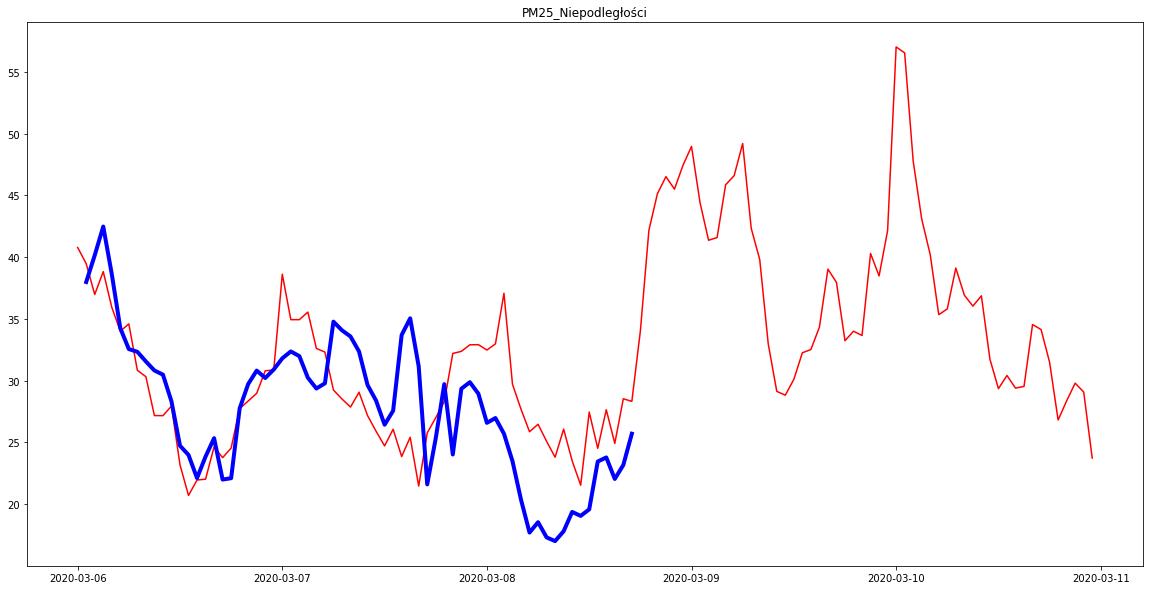

In [29]:
plt.figure(figsize=(20,10))
plt.plot(table_hour['date'], table_hour['pred_xgb'], color='red') #forcast
plt.plot(gios_nie['date'], gios_nie['value'], color='blue', linewidth = 4) #actual

plt.title('PM25_Niepodległości')
plt.show()